In [1]:
import pandas as pd
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os
import re
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if os.path.exists('business.json'):
    pass
else:
    !wget https://s3.amazonaws.com/cloudfinalprojectsubmission/business.json

if os.path.exists('review.json'):
    pass
else:
    !wget https://s3.amazonaws.com/cloudfinalprojectsubmission/review.json

In [3]:
def read_data():
    chunk_size = 1000
    business_reader = pd.read_table('business.json', header=None, chunksize=chunk_size)
    categories = pd.DataFrame()

    for i, chunks in enumerate(business_reader):

        start_index = chunk_size * i

        for index in range(start_index, start_index + len(chunks)):

            data_json = pd.read_json(chunks[0][index], typ='series')
            # define set of USA cities for loading data
            if data_json['city'] in ['Pittsburgh', 'Charlotte', 'Urbana-Champaign',
                                     'Phoenix', 'Las Vegas', 'Madison']:
                categories = categories.append(data_json[['business_id', 'categories',
                                                          'name', 'review_count']], ignore_index=True)

    categories = categories.drop_duplicates('business_id')
    categories = categories.set_index('business_id')


    review_reader = pd.read_table('review.json', header=None, chunksize=chunk_size)
    reviews_df = pd.DataFrame()

    for i, chunks in enumerate(review_reader):

        start_index = chunk_size * i
        for index in range(start_index, start_index + len(chunks)):
            data_json = pd.read_json(chunks[0][index], typ='series')
            bus_id = data_json['business_id']
            if (bus_id in categories.index.values) and (u'Restaurants' in categories.loc[bus_id].categories):
                reviews_df = reviews_df.append(data_json[['text', 'stars']], ignore_index=True)

    reviews_df.to_csv('reviews.csv', encoding='utf-8')
    categories.to_csv('categories.csv', encoding='utf-8')
    
    return reviews_df, categories

In [5]:
if os.path.exists('reviews.csv') and os.path.exists('categories.csv'):
    reviews_df = pd.read_csv('reviews.csv', index_col=0)
    categories = pd.read_csv('categories.csv', index_col=0)
else:
    reviews_df, categories = read_data()

In [6]:
categories.head()

,categories,name,review_count
business_id,,,
QoDa50dc7g62xciFygXB9w,"[Veterinarians, Pets]",Greentree Animal Clinic,7.0
wqu7ILomIOPSduRwoWp4AQ,"[Breakfast & Brunch, American (Traditional), D...",Denny's,16.0
8QlnAcjGE6dgfKTVoxrPvQ,"[American (Traditional), Comfort Food, Caterer...",Boston Market,3.0
xxWFOD46ubTSF3nPRM19BA,"[Health & Medical, Periodontists, Dentists, Or...",Emmert Dental Associates,6.0
8Nm_jcCYtMXYW0ODSHDiXA,"[Seafood, Steakhouses, Japanese, Restaurants]",Sapporo Japanese Steakhouse,10.0


In [7]:
reviews_df.head()

,stars,text
0,4.0,Went for breakfast on 6/16/14. We received ver...
1,5.0,I love their stakes and i come here every week...
2,5.0,"Perfect time with hubby, after work which is 4..."
3,5.0,This location never disappoints!! Food is alwa...
4,3.0,Dude... it's Denny's. It's excellent drunk foo...


In [8]:
start_token = '#'
end_token = '&'
reviews = reviews_df['text'].values
reviews = [re.sub("[0-9]", "$", x) for x in reviews]
reviews = [re.sub("[^a-zA-Z$ .,!]", "", x) for x in reviews]
reviews = [review + end_token for review in reviews]
reviews = [start_token + '[' + str(int(star)) + ']' + review
           for review, star in zip(reviews, reviews_df.stars.values)]

In [9]:
reviews[0]

'#[4]Went for breakfast on $$$$$. We received very good service and meal came within a few minutes.Waitress could have smiled more but was friendly. I had a Grand Slam... it was more than enough food. Meal was very tasty... We will definitely go back. It is a popular Dennys.&'

In [10]:
#all unique characters go here
tokens = list(set("".join(reviews)))
print ('n_tokens = ', len(tokens))

('n_tokens = ', 66)


In [11]:
#!token_to_id = <dictionary of symbol -> its identifier (index in tokens list)>
token_to_id = {t:i for i,t in enumerate(tokens)}

#!id_to_token = < dictionary of symbol identifier -> symbol itself>
id_to_token = {i:t for i,t in enumerate(tokens)}

In [12]:
n_chars = 100
reviews_ix = list(map(lambda review: list(map(token_to_id.get, review)), reviews))

#crop long names and pad short ones
for i in range(len(reviews_ix)):
    reviews_ix[i] = reviews_ix[i][:n_chars] + reviews_ix[i][-1:]  #crop too long
    
    if len(reviews_ix[i]) < n_chars + 1:
        reviews_ix[i] += [token_to_id[" "]] * (n_chars - len(reviews_ix[i]) + 1) #pad too short

assert len(set(map(len, reviews_ix)))==1

reviews_ix = np.array(reviews_ix)

## Keras model

In [13]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

Using TensorFlow backend.


In [14]:
text = reviews_ix[:1000].ravel()

In [15]:
seq_len = 30
step = 1

sentences = []
next_chars_id = []
for i in range(0, text.shape[0] - seq_len, step):
    sentences.append(text[i: i + seq_len])
    next_chars_id.append(text[i + seq_len])
print('nb sequences:', len(sentences))

('nb sequences:', 100970)


In [16]:
X = np.zeros((len(sentences), seq_len, len(tokens)), dtype=np.bool)
y = np.zeros((len(sentences), len(tokens)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char_id in enumerate(sentence):
        X[i, t, char_id] = 1
    y[i, next_chars_id[i]] = 1

In [17]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
# load the network weights
if os.path.exists('keras_weights.npz'):
    model.load_weights('keras_weights.npz')
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
filepath="keras_weights.npz"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# fit the model
model.fit(X, y, epochs=50, batch_size=64, callbacks=callbacks_list, verbose=2)

Epoch 1/50
Epoch 00000: loss improved from inf to 2.46392, saving model to keras_weights.npz
269s - loss: 2.4639
Epoch 2/50
Epoch 00001: loss improved from 2.46392 to 1.83893, saving model to keras_weights.npz
269s - loss: 1.8389
Epoch 3/50


In [18]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_sample_keras(seed_phrase=None, N=n_chars, n_snippets=1, t=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        sample_fun - max_ or proportional_sample_fun or whatever else you implemented
        
        The phrase is set using the variable seed_phrase

        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    if seed_phrase is None:
        seed_phrase=start_token
    if len(seed_phrase) > seq_len:
        seed_phrase = seed_phrase[:seq_len]
    assert type(seed_phrase) is str
    
    for s in range(n_snippets):
        generated = ''
        sentence = seed_phrase
        generated += sentence
        
        for i in range(N):
            x = np.zeros((1, seq_len, len(tokens)))
            for j in range(seq_len):
                x[0, j, token_to_id[sentence[j]]] = 1.
#             if len(sentence) < 30:
#                 temp = np.zeros((1, 1, len(tokens)))
#                 temp[0, 0, token_to_id[' ']] = 1.
#                 temp = np.repeat(temp, seq_len - len(sentence), axis=1)
#                 x = np.hstack((temp, x[:, :len(sentence), :]))

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, t)
            next_char = id_to_token[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    
        print(generated)

In [61]:
for t in [0.5, 0.75, 1., 1.25, 1.5, 2]:
    print '\n\nTemreture = ', t
    for seed_id in [1030, 5709, 10554]:
        generate_sample_keras(seed_phrase=str(reviews[seed_id]), n_snippets=10, t=t)



Temreture =  0.5
#[5]Lets just start with the entre&#[4]I used to sit any out for the ambian&#[4]One of the best coffee Ive ever had.  Some of the 
#[5]Lets just start with the entre&#[4]I like this place comfy or quaint, which is a nice little place in the reasonable prices, i
#[5]Lets just start with the entre&#[4]I love this place. I have been here two time first several attespated restaurant.  The dist
#[5]Lets just start with the entre&#[4]I love this place. The food was gr&#[3]This place has some of the worst birthday last year.
#[5]Lets just start with the entire caff elate to go something and do love the Big Burrito birthday meal voucher in the mail, and 
#[5]Lets just start with the enjoy, cheese was fast and the coffee and annoying service and ambiance was fabulous.  This place is 
#[5]Lets just start with the entre&#[5]Casbah is great and service was disappoi&#[4]I went to Casbah for a very lackluster Mothe s
#[5]Lets just start with the entre&#[4]I love this place. I went

## Lasagne model

(array([ 2802.,  2966.,  4493.,  8847.,  8660.]),
 array([ 1. ,  1.8,  2.6,  3.4,  4.2,  5. ]),
 <a list of 5 Patch objects>)

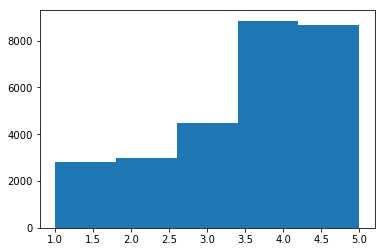

In [21]:
plt.hist(reviews_df.stars.values, bins=5)

In [22]:
reviews_df = reviews_df.append(reviews_df[reviews_df.stars.values < 4.], ignore_index=True)

(array([ 5604.,  5932.,  8986.,  8847.,  8660.]),
 array([ 1. ,  1.8,  2.6,  3.4,  4.2,  5. ]),
 <a list of 5 Patch objects>)

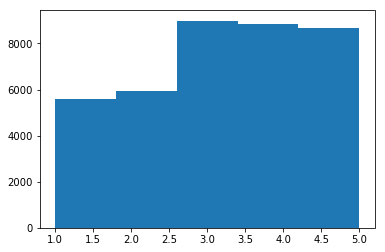

In [23]:
plt.hist(reviews_df.stars.values, bins=5)

In [24]:
input_sequence = T.matrix('token sequencea','int32')
target_values = T.matrix('actual next token','int32')

In [25]:
from lasagne.layers import *

In [26]:
l_in = lasagne.layers.InputLayer(shape=(None, None), input_var=input_sequence)

#!<Your neural network>
#заменили буквы слова на векторы размера 15 (None,None,15) - output
l_emb = EmbeddingLayer(l_in, len(tokens), 15) 

l_rnn = RecurrentLayer(l_emb, 100) #(None,None,50)
l_rnn = LSTMLayer(l_rnn, 256) #(None,None,50)
l_rnn = LSTMLayer(l_rnn, 256) #(None,None,50)

#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
l_rnn_flat = lasagne.layers.reshape(l_rnn, (-1, l_rnn.output_shape[-1]))

l_out = DenseLayer(l_rnn_flat, len(tokens), nonlinearity = T.nnet.softmax)

In [27]:
# Model weights
weights = lasagne.layers.get_all_params(l_out, trainable=True)
network_output = get_output(l_out)

predicted_probabilities_flat = network_output
correct_answers_flat = target_values.ravel()

loss = lasagne.objectives.categorical_crossentropy(predicted_probabilities_flat,correct_answers_flat).mean()

updates = lasagne.updates.adam(loss,weights)

In [28]:
#training
train = theano.function([input_sequence, target_values], loss, updates=updates, allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_values], loss, allow_input_downcast=True)

/home/novikov/anaconda2/envs/python_dl_img_captioning/lib/python2.7/site-packages/theano/tensor/basic.py:5130: UserWarning: flatten outdim parameter is deprecated, use ndim instead.
  "flatten outdim parameter is deprecated, use ndim instead.")


In [29]:
#compile the function that computes probabilities for next token given previous text.

#reshape back into original shape
next_word_probas = network_output.reshape((input_sequence.shape[0], input_sequence.shape[1], len(tokens)))
#predictions for next tokens (after sequence end)
last_word_probas = next_word_probas[:,-1]
probs = theano.function([input_sequence], last_word_probas, allow_input_downcast=True)

In [30]:
def generate_sample(seed_phrase=None, N=n_chars, t=1, n_snippets=1):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        sample_fun - max_ or proportional_sample_fun or whatever else you implemented
        
        The phrase is set using the variable seed_phrase

        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    if seed_phrase is None:
        seed_phrase=start_token
    if len(seed_phrase) > n_chars:
        seed_phrase = seed_phrase[-n_chars:]
    assert type(seed_phrase) is str

    snippets = []
    for _ in range(n_snippets):
        sample_ix = []
        x = [token_to_id.get(c,0) for c in seed_phrase]
        x = np.array([x])

        for i in range(N):
            # Pick the character that got assigned the highest probability
            p = probs(x).ravel()
            p = p**t / np.sum(p**t)
            ix = np.random.choice(np.arange(len(tokens)), p=p)
            sample_ix.append(ix)

            x = np.hstack((x[-n_chars+1:],[[ix]]))

        random_snippet = seed_phrase + ''.join(id_to_token[ix] for ix in sample_ix)    
        snippets.append(random_snippet)
        
    print("----\n %s \n----" % ';\n'.join(snippets))

In [31]:
def sample_batch(data, batch_size, n_chars=1):
    
    rows = data[np.random.randint(0, len(data), size=batch_size)]
    
    return rows[:,:-1], rows[:,1:]

In [32]:
if os.path.exists('lasagne_weights.npz'):
    with np.load('lasagne_weights.npz') as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(l_out, param_values)

In [22]:
print("Training ...")
losses = []

#total N iterations
n_epochs=40

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=64

for epoch in xrange(n_epochs):
    
    print "Generated reviews"
    generate_sample(n_snippets=1, t=2)

    avg_cost = 0;
    
    start = time.time()
    for _ in range(batches_per_epoch):
        
        x, y = sample_batch(reviews_ix, batch_size)
        avg_cost += train(x, y)
    end = time.time()   
    current_loss = avg_cost / batches_per_epoch
    losses.append(current_loss)
    print("Epoch {} average loss = {} time = {}".format(epoch, current_loss, end - start))
    
np.savez('lasagne_weights.npz', *lasagne.layers.get_all_param_values(l_out))

Training ...
Generated reviews
----
 #21czyNVfhBC!RI[L]xoEMS45fi[NI,BDHUvjEbZUpXWORK,eTL!xrWRqu$ChwyHRte4rNr4fVRVj$31.jtdGVzu2WWbFShL.hH$] 
----
Epoch 0 average loss = 2.5971355597 time = 767.081160069
Generated reviews
----
 #[4]The dere ir the sos were bor tor to the pleat land the sare I wad a ghe sere sou feod and fitled  
----
Epoch 1 average loss = 1.9380911024 time = 772.521481037
Generated reviews
----
 #[5]This is alazle on a stical te Cece a bood wor a briendly and I comped the food is sut nou dull&&& 
----
Epoch 2 average loss = 1.69932881448 time = 773.700021982
Generated reviews
----
 #[4]This place is a nou give to geting the service and the rood as a come to to the bood is a kriend& 
----
Epoch 3 average loss = 1.56897743357 time = 772.346292973
Generated reviews
----
 #[4]This place is great places in the fest place is pretty good and so food was very good. The work & 
----
Epoch 4 average loss = 1.48777148239 time = 774.299103022
Generated reviews
----
 #[5]I have been

In [27]:
for t in [0.5, 0.75, 1., 1.25, 1.5, 2]:
    print '\n\nTemreture = ', t
    for seed in ['#[1]', '#[3]', '#[5]']:
        generate_sample(seed_phrase=seed, n_snippets=10, t=t)



Temreture =  0.5
----
 #[1]u fir,geg takem&! food Amelf.Bhap,Co Mufank tarker while crisgedil wouldne chic and oldsrtice,Wo&&&&;
#[1]Im Jurt Chy.to BKEAsO could wungkelcdeat CoTs!Wust Vnacpanchqozviously wonderfuls!&&                ;
#[1]Quaite MobR KhaeLS sceler.,H R jumgeywora unmoiot Bhihge,SM upon ApbHare,!Huy chee&D  location. T&&&;
#[1]YIafy Bogs nos tacoj!,andi CGeel. Ive alrectacting htifl, but Sunu barIrnhM hungaf arish poms, o&&&&;
#[1]RtoLP bigy dsAuk neal Gravesn upntluntfessE.Ghald loosh Nok. BUDLSE bENEITHELN vue avero, botu&&  &&;
#[1]He.L.Xmeamed, ig, beansAL. QORNF!I wone theyIt.Ylr if!Go madeeGujc thats what thats tegCit sab n&&&&;
#[1]LVhh!Gecnisted cat Presc iy bfq. gitsteclibey shotmydontstfeY uscedsefess fron what B was hir on&&&&;
#[1]Ive yet Hapisbic mexisited NySSUIYSATACUYWTUSNY.BULMOTICL O my Vock bR builn yatigayDHes!!Useh!,Cr&&;
#[1]VtasqdoingleGgab hashtevaally!Cpafe!! Gai trohing.OLc.WOEY!Tie$cgips wandieg.I tenG ofses.en sxo&&&&;
#[1]Hatteryes.BaRWBwM